In [132]:
import os

from math import ceil, floor

import copy

import pickle

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets.vision import VisionDataset

from tqdm import tqdm

from sklearn.manifold import TSNE

from datasets import BadNetsDataset, WaNetDataset, SIGDataset
from simclr import SimClrBackbone

In [133]:
device = "cuda"

### Poison dataset

In [134]:
def prepare_poison_dataset(dataset_name: str, train: bool) -> VisionDataset:
    clean_dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=train)

    if dataset_name == "badnets":
        poison_dataset = BadNetsDataset(clean_dataset, 1, "triggers/trigger_10.png", seed=1)
    elif dataset_name == "wanet":
        poison_dataset = WaNetDataset(clean_dataset, 0, seed=1)
    elif dataset_name == "sig":
        poison_dataset = SIGDataset(clean_dataset, 1, 20, 6, seed=1)
    else:
        raise Exception("Invalid dataset")

    poison_indices = np.array([poison_dataset.is_poison(i) for i in range(len(poison_dataset))])

    return poison_dataset, poison_indices

### Load SimCLR model

In [135]:
def load_simclr(simclr_model_name: str) -> SimClrBackbone:
    model = SimClrBackbone()
    out = os.path.join('./saved_models/', simclr_model_name)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)
    model.eval()
    return model

### Extract SimCLR features for all images

In [136]:
def extract_simclr_features(model: SimClrBackbone, dataset: VisionDataset):

    simclr_feature_size = 128
    num_examples = len(dataset)

    features = np.zeros((num_examples, simclr_feature_size))
    labels_poison = np.zeros((num_examples))
    labels_true = np.zeros((num_examples))

    batch_size = 256
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        features[i*batch_size : i*batch_size+len(features_batch)] = features_batch
        labels_poison[i*batch_size : i*batch_size+len(labels_batch_poison)] = labels_batch_poison.long()
        labels_true[i*batch_size : i*batch_size+len(labels_batch_true)] = labels_batch_true.long()

    labels_poison = labels_poison.astype(int)
    labels_true = labels_true.astype(int)

    return features, labels_poison, labels_true

### Plot t-SNE features

In [137]:
def calculate_tsne_features(features: np.array, perplexity: int = 50) -> np.array:
    tsne = TSNE(n_components = 2, perplexity = perplexity)
    tsne_features = tsne.fit_transform(features)
    return tsne_features

def plot_tsne_features(tsne_features: np.array, labels: np.array, poison_indices: np.array, legend: bool = True) -> None:
    num_classes = int(max(labels).item())

    # label poison examples as 10
    labels_10 = copy.deepcopy(labels)
    labels_10[poison_indices] = 10

    for i in range(num_classes):
        plt.scatter(tsne_features[labels_10==i,1], tsne_features[labels_10==i,0])
    plt.scatter(tsne_features[labels_10==10,1], tsne_features[labels_10==10,0], c = "black", marker= "x")

    if legend:
        plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()


def calculate_and_plot_tsne(features: np.array, labels: np.array, poison_indices: np.array, subset_size: int = None, legend: bool = True) -> np.array:
    # Plot only a subset
    if subset_size is None:
        subset_size = len(features)
    features_subset = features[:subset_size]
    labels_subset = labels[:subset_size]
    poison_indices_subset = poison_indices[:subset_size]
    
    tsne_features = calculate_tsne_features(features_subset)
    plot_tsne_features(tsne_features, labels_subset, poison_indices_subset, legend=legend)
    


### Util functions for all cleanses

In [138]:
def evaluate_cleanse(poison_predicted: np.array, poison_indices: np.array):

    tp = (poison_indices & poison_predicted).sum()
    fp = (np.invert(poison_indices) & poison_predicted).sum()
    fn = (poison_indices & np.invert(poison_predicted)).sum()
    tn = (np.invert(poison_indices) & np.invert(poison_predicted)).sum()

    fnr = fn/(fn+tp) if fn+tp!=0 else 0
    tnr = tn/(tn+fp) if tn+fp!=0 else 0
    poison_rate = fn/(fn+tn) if fn+tn!=0 else 0

    print(f"{tp} \t {fp}")
    print(f"{fn} \t {tn}")
    print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
    print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
    print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

In [139]:
def save_predicted_labels(labels_predicted: np.array, save_name: str):
    with open(f"./cleansed_labels/{save_name}.pkl", "wb") as f:
        pickle.dump(labels_predicted, f)

In [140]:
def plot_histogram_poisoned(values: np.array, poison_indices: np.array = None, is_integer: bool = False, bins_num: int = 100, separation_line: float = None) -> None:
    if poison_indices is not None:
        values_clean = values[np.invert(poison_indices)]
        values_poisoned = values[poison_indices]
    else:
        values_clean = values[:]
        values_poisoned = []

    bins = np.linspace(floor(np.min(values)), ceil(np.max(values)), int(np.max(values)) if is_integer else bins_num)
    plt.hist(values_clean, bins, alpha=0.5, label='clean')
    plt.hist(values_poisoned, bins, alpha=0.5, label='poisoned')

    if separation_line:
        plt.axvline(separation_line, color='red', linestyle='dashed', linewidth=1)

    plt.legend(loc='upper right')
    plt.show()

## Step 1: Non-disruptive cleanse

### kNN

In [141]:
from sklearn.neighbors import KNeighborsClassifier

def knn_cleanse(features: np.array, labels_poison: np.array, num_classes: int) -> np.array:
    
    examples_per_class = len(features) / num_classes
    knn = KNeighborsClassifier(n_neighbors=int(examples_per_class/2))
    knn.fit(features, labels_poison)
    labels_predicted = knn.predict(features)

    return labels_predicted != labels_poison

------------------------------------

CIFAR-10 train \
BadNets 

    4905 	 9481
    95 	 35519
    Percentage of poisoned images (out of all poisoned) kept:  1.90%
    Percentage of clean images (out of all clean) kept:  78.93%
    Percentage of remaining poisoned images (out of all remaining):  0.27%

CIFAR-10 test \
BadNets 

    960 	 2056
    40 	 6944
    Percentage of poisoned images (out of all poisoned) kept:  4.00%
    Percentage of clean images (out of all clean) kept:  77.16%
    Percentage of remaining poisoned images (out of all remaining):  0.57%

------------------------------------

CIFAR-10 train \
WaNet 

    3975 	 14331
    1025 	 30669
    Percentage of poisoned images (out of all poisoned) kept:  20.50%
    Percentage of clean images (out of all clean) kept:  68.15%
    Percentage of remaining poisoned images (out of all remaining):  3.23%

CIFAR-10 test \
WaNet 

    712 	 3058
    288 	 5942
    Percentage of poisoned images (out of all poisoned) kept:  28.80%
    Percentage of clean images (out of all clean) kept:  66.02%
    Percentage of remaining poisoned images (out of all remaining):  4.62%

------------------------------------

CIFAR-10 train \
SIG

    0 	 9195
    500 	 40305
    Percentage of poisoned images (out of all poisoned) kept:  100.00%
    Percentage of clean images (out of all clean) kept:  81.42%
    Percentage of remaining poisoned images (out of all remaining):  1.23%

CIFAR-10 test \
SIG

    0 	 2179
    100 	 7721
    Percentage of poisoned images (out of all poisoned) kept:  100.00%
    Percentage of clean images (out of all clean) kept:  77.99%
    Percentage of remaining poisoned images (out of all remaining):  1.28%


### Energy

In [142]:
class EnergyClassifier():

    def __init__(self, t=1):
        self.t = t

    def fit(self, X, y):
        self.X = X
        self.y = y
        
        self.C = int(np.max(y))
        self.Ic = {c:[i for i in range(len(y)) if y[i]==c] for c in range(self.C)}
        
    def predict_index(self, i):
        # consider improving with numpy and batch

        xi = self.X[i]

        exp_all = np.exp([xi*self.X[k]/self.t for k in range(len(self.X))])
        sum_exp_all_except_xi = np.sum([exp_all[k] for k in range(len(self.X)) if k!=i])
        mean_exp_c = [np.mean([exp_all[k] for k in self.Ic[c] if k!=i]) for c in range(self.C)]
    
        Scs = mean_exp_c / sum_exp_all_except_xi
        return np.argmax(Scs)

    def predict(self):
        predicted = np.zeros((len(self.X)))
        for i in range(len(self.X)):
            predicted[i] = self.predict_index(i)

In [143]:
# TODO remove??

# def energy_cleanse(features: np.array, labels_poison: np.array) -> np.array:
    
#     if DATASET == "badnets":
#         T = 100
#     elif DATASET == "wanet":
#         T = 10
#     elif DATASET == "sig":
#         T = 1
#     else:
#         raise Exception("Invalid dataset")

#     energy = EnergyClassifier(t=T)
#     energy.fit(features, labels_poison)
#     labels_predicted = energy.predict()

#     return labels_predicted

# if RUN_ENERGY:
#     labels_predicted_energy = energy_cleanse(features, labels_poison)
#     evaluate_cleanse(labels_predicted_energy != labels_poison, poison_indices)

#     save_name = f"__NEW__{DATASET_NAME}-Energy-{'train' if TRAIN else 'test'}"
#     save_predicted_labels(labels_predicted_knn, save_name)

CIFAR-10 train \
BadNets

	50000 / 50000
		4618 	 12732
		382 	 32268
	Percentage of poisoned images (out of all poisoned) kept:  7.64%
	Percentage of clean images (out of all clean) kept:  71.71%
	Percentage of remaining poisoned images (out of all remaining):  1.17%

CIFAR-10 test \
BadNets

	10000 / 10000
		920 	 2585
		80 	 6415
	Percentage of poisoned images (out of all poisoned) kept:  8.00%
	Percentage of clean images (out of all clean) kept:  71.28%
	Percentage of remaining poisoned images (out of all remaining):  1.23%

--------------------------------------------------------------------------------

CIFAR-10 train \
WaNet

	50000 / 50000
		4725 	 14096
		275 	 30904
	Percentage of poisoned images (out of all poisoned) kept:  5.50%
	Percentage of clean images (out of all clean) kept:  68.68%
	Percentage of remaining poisoned images (out of all remaining):  0.88%

CIFAR-10 test \
WaNet

	10000 / 10000
		951 	 2851
		49 	 6149
	Percentage of poisoned images (out of all poisoned) kept:  4.90%
	Percentage of clean images (out of all clean) kept:  68.32%
	Percentage of remaining poisoned images (out of all remaining):  0.79%

--------------------------------------------------------------------------------

CIFAR-10 train \
SIG

	50000 / 50000
		2 	 15777
		498 	 33723
	Percentage of poisoned images (out of all poisoned) kept:  99.60%
	Percentage of clean images (out of all clean) kept:  68.13%
	Percentage of remaining poisoned images (out of all remaining):  1.46%

### LogReg 

In [144]:
# TODO cleanup, delete?

In [145]:
class LogReg(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(LogReg, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    def forward(self, x):
        return torch.softmax(self.linear(x), dim=1)

In [146]:
class SimClrFeaturesDataset(VisionDataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    def __len__(self):
        return len(self.features)

In [147]:
# if RUN_LOGREG:
    
#     BATCH_SIZE = 1024
#     NUM_MODELS = 10
#     EPOCHS = 60

#     classifications = np.zeros((NUM_MODELS, len(features)))

#     for num_model in range(NUM_MODELS):
#         print(f"Learning logistic regression model {num_model+1}/{NUM_MODELS}")
#         simclr_features_dataset = SimClrFeaturesDataset(features, labels_poison)
#         dataloader = DataLoader(dataset=simclr_features_dataset, batch_size=BATCH_SIZE, shuffle=True) 
#         model = LogReg(128, 10)
#         optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-1)
#         criterion = torch.nn.CrossEntropyLoss()
        
#         # train
#         for epoch in range(EPOCHS):
#             correct = 0
#             for i, (batch_features, batch_labels) in enumerate(dataloader):
#                 batch_features, batch_labels = batch_features.float(), batch_labels.long()

#                 optimizer.zero_grad()
#                 outputs = model(batch_features)
#                 loss = criterion(outputs, batch_labels)
#                 loss.backward()
#                 optimizer.step()
#                 _, predicted = torch.max(outputs.data, 1)
#                 correct += (predicted == batch_labels).sum()
#             accuracy = 100 * (correct.item()) / len(simclr_features_dataset)
#         print(f"Accuracy: {accuracy}")

#         # get model classifications
#         dataloader = DataLoader(dataset=simclr_features_dataset, batch_size=BATCH_SIZE, shuffle=False) 
#         for i, (batch_features, batch_labels) in enumerate(dataloader):
#             batch_features, batch_labels = batch_features.float(), batch_labels.long()

#             outputs = model(batch_features)
#             _, predicted = torch.max(outputs.data, 1)
#             predicted = predicted.numpy()
#             classifications[num_model, (i*BATCH_SIZE):(i*BATCH_SIZE+len(predicted))] = predicted


In [148]:
# if RUN_LOGREG:

#     labels_poison_repeated = np.tile(labels_poison, (NUM_MODELS,1))
#     misclassifications = np.sum(classifications != labels_poison_repeated, axis=0)

#     misclassifications_poisoned = misclassifications[poison_indices]
#     misclassifications_clean = misclassifications[np.invert(poison_indices)]

#     # print(misclassifications_poisoned.shape)
#     # print(misclassifications_clean.shape)

#     # print(np.average(misclassifications_poisoned))
#     # print(np.average(misclassifications_clean))

#     bins = np.linspace(0, np.max(misclassifications), np.max(misclassifications))
#     plt.hist(misclassifications_clean, bins, alpha=0.5, label='clean')
#     plt.hist(misclassifications_poisoned, bins, alpha=0.5, label='poisoned')
#     plt.legend(loc='upper right')
#     plt.show()

In [149]:
# if RUN_LOGREG:

#     class_num = 1

#     misclassifications_class = misclassifications[labels_poison == class_num]
#     misclassifications_class_poisoned = misclassifications[np.logical_and(labels_poison == class_num, poison_indices)]
#     misclassifications_class_clean = misclassifications[np.logical_and(labels_poison == class_num, np.invert(poison_indices))]

#     print((labels_poison == class_num & np.invert(poison_indices)).shape)
#     print(misclassifications_class.shape)
#     print(misclassifications_class_poisoned.shape)
#     print(misclassifications_class_clean.shape)

#     bins = np.linspace(0, np.max(misclassifications_class), np.max(misclassifications_class))
#     plt.hist(misclassifications_class_clean, bins, alpha=0.5, label='clean')
#     plt.hist(misclassifications_class_poisoned, bins, alpha=0.5, label='poisoned')
#     plt.legend(loc='upper right')
#     plt.show()

## Disruptive detection

### Centroid

In [150]:
def centroid_cleanse(features: np.array, poison_indices: np.array) -> np.array:
    centroid = np.sum(features, axis=0) / features.shape[0]
    distances = np.linalg.norm(features - centroid, axis=1)
    
    plot_histogram_poisoned(distances, poison_indices)

### Gauss 

In [151]:
from scipy.stats import multivariate_normal

def gauss_cleanse(features: np.array, discard_percentage: float, poison_indices: np.array = None) -> np.array:
    mean = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=0)

    probabilities = multivariate_normal.pdf(features, mean=mean, cov=cov, allow_singular=True)
    probabilities[probabilities <= 0] = 1e-100
    probabilities = -np.log(probabilities)

    discard_line = np.percentile(probabilities, (1-discard_percentage)*100)
    plot_histogram_poisoned(probabilities, poison_indices, separation_line=discard_line)

    predicted_poison_indices = probabilities > discard_line
    return predicted_poison_indices

## Poison reclassification

### Weak binary classifier 

In [152]:
class PoisonClassificationDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, poison_indices: np.array) -> None:
        self.original_dataset = original_dataset
        self.poison_indices = poison_indices

    def __len__(self) -> int:
        return len(self.original_dataset)
    
    def __getitem__(self, index: int):
        return self.original_dataset[index][0], torch.tensor(self.poison_indices[index])

In [153]:
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler

class ConvolutionalBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Linear(1568, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x) -> torch.tensor:
        return self.layers(x)

def train_binary_classifier(dataset: VisionDataset, predicted_poison_indices: np.array) -> nn.Module:
    poison_classification_dataset = PoisonClassificationDataset(dataset, predicted_poison_indices)
    # sampler for class imbalance
    positives = sum([1 for _, target in poison_classification_dataset if target==1])
    total = len(poison_classification_dataset)
    positive_weight = 0.5 / positives
    negative_weight = 0.5 / (total - positives)
    weights = [positive_weight if target==1 else negative_weight for _, target in poison_classification_dataset]
    sampler = WeightedRandomSampler(weights, len(weights))

    dataloader = DataLoader(poison_classification_dataset, batch_size=128, sampler=sampler)
    model = ConvolutionalBinaryClassifier().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1-1e-4)
    num_epochs = 10

    for _ in tqdm(range(num_epochs)):
        for _, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device).float()
            optimizer.zero_grad()
            logits = model.forward(inputs).squeeze(-1)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    return model

def binary_reclassification(dataset: VisionDataset, model: nn.Module):
    predicted_poison_indices = np.zeros((len(dataset)))
    batch_size = 128
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for i, (inputs, _, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        with torch.no_grad():
            logits = model.forward(inputs).squeeze(-1)
            predictions = (logits>0.5).cpu().numpy()
        predicted_poison_indices[i*batch_size : i*batch_size+len(predictions)] = predictions
    return predicted_poison_indices==1
        


### Strong multiclass classifier

In [154]:
from torchvision import transforms

class CleansedDataset(VisionDataset):

    def __init__(self, poison_dataset: VisionDataset, predicted_poison: np.array, transforms: torch.nn.Module = None):
        self.data = [poison_dataset[i][0] for i in range(len(poison_dataset)) if not predicted_poison[i]]
        self.labels = [poison_dataset[i][1] for i in range(len(poison_dataset)) if not predicted_poison[i]]
        self.transforms = transforms

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data[index]
        label = self.labels[index]

        if self.transforms:
            item = self.transforms(item)

        return item, label

In [155]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [156]:
def train_multiclass_classifier(dataset: VisionDataset, predicted_poison_indices: np.array) -> nn.Module:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    cleansed_dataset = CleansedDataset(dataset, predicted_poison_indices, transform_train)
    dataloader = DataLoader(cleansed_dataset, batch_size=128, shuffle=True, num_workers=0)

    model = ResNet18()
    model.to(device)

    epochs = 35
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    model.train()
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        correct = 0
        total = 0
        for _, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        acc = 100.*correct/total
        scheduler.step()
        print(epoch, train_loss, acc)
    model.eval()
    return model

In [157]:
def multiclass_reclassification(dataset: VisionDataset, model: nn.Module, true_labels: np.array):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_dataset = CleansedDataset(dataset, np.zeros(len(dataset)), transform_train)
    
    predicted_labels = np.zeros((len(dataset)))
    batch_size = 128
    dataloader = DataLoader(transform_dataset, batch_size=batch_size, shuffle=False)
    for i, (inputs, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        with torch.no_grad():
            logits = model.forward(inputs)
            predictions = torch.argmax(logits, 1).cpu().numpy()
        predicted_labels[i*batch_size : i*batch_size+len(predictions)] = predictions
    return predicted_labels!=true_labels

# Final cleanse pipeline

In [158]:
device = "cuda"

dataset_name = "sig"

train = True
simclr_model_name = f"{dataset_name}-SimCLR.pt"

dataset, true_poison_indices = prepare_poison_dataset(dataset_name, train)
simclr = load_simclr(simclr_model_name)
features, labels_poison, labels_true = extract_simclr_features(simclr, dataset)
num_classes = int(max(labels_poison).item())

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [159]:
# Hiperparameters

gauss_discard = 0.005
tsne_perplexity = len(dataset) / 100

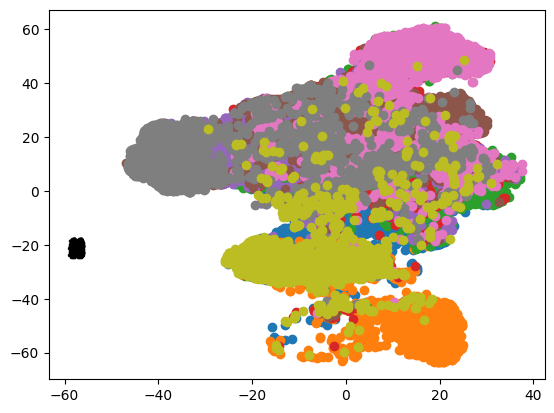

In [160]:
tsne_features = calculate_tsne_features(features, perplexity=tsne_perplexity)
plot_tsne_features(tsne_features, labels_poison, true_poison_indices, legend=False)

In [161]:
# Nondisruptive cleanse
predicted_poison_indices_nondisruptive = knn_cleanse(features, labels_poison, num_classes)
evaluate_cleanse(predicted_poison_indices_nondisruptive, true_poison_indices)

0 	 10509
500 	 38991
Percentage of poisoned images (out of all poisoned) kept:  100.00%
Percentage of clean images (out of all clean) kept:  78.77%
Percentage of remaining poisoned images (out of all remaining):  1.27%


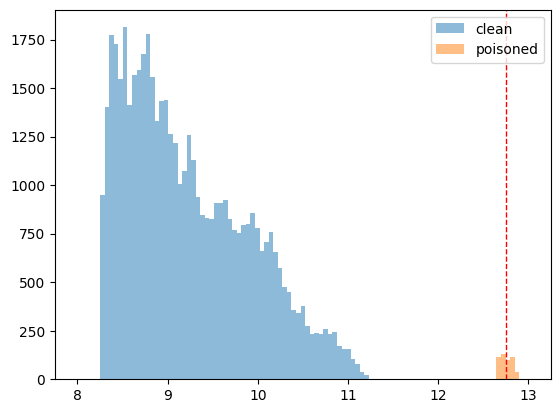

250 	 0
250 	 49500
Percentage of poisoned images (out of all poisoned) kept:  50.00%
Percentage of clean images (out of all clean) kept:  100.00%
Percentage of remaining poisoned images (out of all remaining):  0.50%


In [162]:
# Disruptive cleanse
predicted_poison_indices_disruptive = gauss_cleanse(tsne_features, gauss_discard, poison_indices=true_poison_indices)
evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices)

In [163]:
# Disruptive cleanse reclassification

poison_binary_classifier_model = train_binary_classifier(dataset, predicted_poison_indices_disruptive)
predicted_poison_indices_binary_reclassification = binary_reclassification(dataset, poison_binary_classifier_model)
evaluate_cleanse(predicted_poison_indices_binary_reclassification, true_poison_indices)

C:\Users\Luka\AppData\Local\Temp\ipykernel_5168\2447615426.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return self.original_dataset[index][0], torch.tensor(self.poison_indices[index])
100%|██████████| 10/10 [01:46<00:00, 10.60s/it]


500 	 3
0 	 49497
Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  99.99%
Percentage of remaining poisoned images (out of all remaining):  0.00%


In [164]:
# Combine cleanses

predicted_poison_indices_final = predicted_poison_indices_nondisruptive | predicted_poison_indices_binary_reclassification
evaluate_cleanse(predicted_poison_indices_final, true_poison_indices)

500 	 10510
0 	 38990
Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  78.77%
Percentage of remaining poisoned images (out of all remaining):  0.00%


In [165]:
poison_multiclass_classifier_model = train_multiclass_classifier(dataset, predicted_poison_indices_final)

  3%|▎         | 1/35 [00:39<22:28, 39.66s/it]

0 545.8242846727371 36.69402410874583


  6%|▌         | 2/35 [01:19<21:46, 39.58s/it]

1 357.4554927945137 57.41215696332393


  9%|▊         | 3/35 [01:58<21:07, 39.61s/it]

2 261.2015476822853 69.71531161836369


 11%|█▏        | 4/35 [02:38<20:29, 39.66s/it]

3 199.18800845742226 76.99410105155168


 14%|█▍        | 5/35 [03:16<19:35, 39.20s/it]

4 157.29850989580154 82.04667863554758


 17%|█▋        | 6/35 [03:57<19:06, 39.53s/it]

5 125.40090449154377 85.4526801744037


 20%|██        | 7/35 [04:37<18:32, 39.74s/it]

6 107.42879831790924 87.71992818671454


 23%|██▎       | 8/35 [05:17<17:57, 39.89s/it]

7 93.36268931627274 89.32033854834573


 26%|██▌       | 9/35 [05:57<17:19, 39.97s/it]

8 88.06478130817413 90.04873044370352


 29%|██▊       | 10/35 [06:37<16:36, 39.86s/it]

9 81.43234018236399 90.59245960502693


 31%|███▏      | 11/35 [07:15<15:45, 39.40s/it]

10 78.7343193590641 90.86175942549372


 34%|███▍      | 12/35 [07:54<14:59, 39.09s/it]

11 75.37302380055189 91.34393434213901


 37%|███▋      | 13/35 [08:28<13:51, 37.79s/it]

12 71.98343548923731 91.71069505001283


 40%|████      | 14/35 [09:03<12:52, 36.80s/it]

13 72.13298431038857 91.87483970248782


 43%|████▎     | 15/35 [09:37<11:59, 35.97s/it]

14 69.22409297525883 92.09540907925108


 46%|████▌     | 16/35 [10:09<10:58, 34.67s/it]

15 66.84710080176592 92.3903565016671


 49%|████▊     | 17/35 [10:40<10:07, 33.74s/it]

16 67.65575015544891 92.29033085406515


 51%|█████▏    | 18/35 [11:12<09:22, 33.11s/it]

17 64.2828274294734 92.56219543472686


 54%|█████▍    | 19/35 [11:43<08:42, 32.67s/it]

18 64.15658781677485 92.66991536291357


 57%|█████▋    | 20/35 [12:15<08:05, 32.34s/it]

19 62.854452058672905 92.83406001538856


 60%|██████    | 21/35 [12:47<07:29, 32.12s/it]

20 62.40099459141493 92.93921518338036


 63%|██████▎   | 22/35 [13:23<07:15, 33.52s/it]

21 59.904861748218536 92.99820466786356


 66%|██████▌   | 23/35 [14:03<07:02, 35.23s/it]

22 59.736949265003204 93.2623749679405


 69%|██████▊   | 24/35 [14:42<06:41, 36.52s/it]

23 58.66738909482956 93.35470633495768


 71%|███████▏  | 25/35 [15:21<06:12, 37.22s/it]

24 57.76928362995386 93.5701461913311


 74%|███████▍  | 26/35 [16:01<05:41, 37.95s/it]

25 56.99193135648966 93.47781482431392


 77%|███████▋  | 27/35 [16:40<05:06, 38.32s/it]

26 57.03466885909438 93.50346242626314


 80%|████████  | 28/35 [17:18<04:28, 38.35s/it]

27 57.64275700598955 93.50089766606823


 83%|████████▎ | 29/35 [17:56<03:49, 38.32s/it]

28 55.72175941616297 93.77789176711977


 86%|████████▌ | 30/35 [18:35<03:11, 38.31s/it]

29 52.51700795814395 94.16004103616312


 89%|████████▊ | 31/35 [19:13<02:33, 38.31s/it]

30 55.30984591320157 93.73685560400102


 91%|█████████▏| 32/35 [19:51<01:54, 38.30s/it]

31 54.138463750481606 93.83431649140806


 94%|█████████▍| 33/35 [20:32<01:18, 39.01s/it]

32 55.386035934090614 93.68043087971274


 97%|█████████▋| 34/35 [21:17<00:40, 40.76s/it]

33 53.709880113601685 93.89330597589125


100%|██████████| 35/35 [21:55<00:00, 37.58s/it]

34 51.8300153799355 94.21133624006156


In [166]:
predicted_poison_indices_multiclass_reclassification = multiclass_reclassification(dataset, poison_multiclass_classifier_model, labels_poison)
evaluate_cleanse(predicted_poison_indices_multiclass_reclassification, true_poison_indices)

500 	 12821
0 	 36679
Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  74.10%
Percentage of remaining poisoned images (out of all remaining):  0.00%


In [167]:
# Final cleanse report
print("---------------------------------------")
train_string = "train" if train else "test"
print(f"{dataset_name} {train_string}")
print("\nNon-disruptive cleanse: ")
evaluate_cleanse(predicted_poison_indices_nondisruptive, true_poison_indices)
print("\nDisruptive cleanse: ")
evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices)
print("\nReclassify (binary) disruptive cleanse: ")
evaluate_cleanse(predicted_poison_indices_binary_reclassification, true_poison_indices)
print("\nCombined cleanse: ")
evaluate_cleanse(predicted_poison_indices_final, true_poison_indices)
print("\nReclassify (multiclass) combined cleanse: ")
evaluate_cleanse(predicted_poison_indices_multiclass_reclassification, true_poison_indices)
print("---------------------------------------")

---------------------------------------
sig train

Non-disruptive cleanse: 
0 	 10509
500 	 38991
Percentage of poisoned images (out of all poisoned) kept:  100.00%
Percentage of clean images (out of all clean) kept:  78.77%
Percentage of remaining poisoned images (out of all remaining):  1.27%

Disruptive cleanse: 
250 	 0
250 	 49500
Percentage of poisoned images (out of all poisoned) kept:  50.00%
Percentage of clean images (out of all clean) kept:  100.00%
Percentage of remaining poisoned images (out of all remaining):  0.50%

Reclassify (binary) disruptive cleanse: 
500 	 3
0 	 49497
Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  99.99%
Percentage of remaining poisoned images (out of all remaining):  0.00%

Combined cleanse: 
500 	 10510
0 	 38990
Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  78.77%
Percentage of remaining poisoned images (